In [259]:
from itertools import product
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output
import plotly.express as px
from matplotlib.backend_bases import MouseButton
from matplotlib.patches import Arrow, Circle

In [260]:
%matplotlib widget

In [261]:
unit_range = 10.0
unit_speed = 2.0
unit_health = 100.0
unit_dps = 2.0
enemy_range = 1.0
enemy_speed = 0.1
enemy_health = 100.0
enemy_dps = 2.0

In [262]:
enemy_positions = np.array([[100, 50], [100, 150]])
unit_position = np.array([-10.0, 0.0])

In [263]:
def loss_fn(x):
    loss = 0.0
    for y in enemy_positions:
        d = np.linalg.norm(x - y)
        unit_margin = max(0, d - unit_range) / unit_speed
        enemy_margin = max(0, d - enemy_range) / enemy_speed
        # loss += (unit_margin - enemy_margin) / (1 + unit_margin)
        # loss += (unit_margin - enemy_margin)
        #loss += np.exp(unit_margin-enemy_margin)
        # loss += unit_margin
        loss -= enemy_margin
        unit_kill_time = enemy_health / unit_dps
        enemy_kill_time = unit_health / enemy_dps
        # loss += unit_kill_time
        loss -= enemy_kill_time
        # loss -= 1e-1 * d
    # loss += 1e-2 * np.linalg.norm(x - unit_position)
    return loss

In [264]:
x = np.linspace(-20, 20, num=100)
y = np.linspace(-20, 20, num=100)
f = np.array([[loss_fn(np.array((xi, yi))) for xi in x] for yi in y])
f

array([[-3550.10960361, -3544.29367121, -3538.4859986 , ...,
        -3031.39365979, -3026.61198372, -3021.84400408],
       [-3544.7785776 , -3538.95382315, -3533.1373071 , ...,
        -3025.10425315, -3020.31163574, -3015.53269528],
       [-3539.45897917, -3533.62540105, -3527.80003981, ...,
        -3018.82524285, -3014.02166012, -3009.23173445],
       ...,
       [-3094.04324386, -3087.40131937, -3080.76523437, ...,
        -2482.37021017, -2476.47644067, -2470.592815  ],
       [-3090.06945857, -3083.41977917, -3076.77591405, ...,
        -2477.50319481, -2471.59838818, -2465.70367822],
       [-3086.11228898, -3079.45488   , -3072.80326019, ...,
        -2472.65569508, -2466.73988615, -2460.83412678]], shape=(100, 100))

In [265]:
options = dict(
    disp=True,
)
res = minimize(loss_fn, x0=unit_position, options=options)
res.x

         Current function value: -662165774.759512
         Iterations: 2
         Function evaluations: 381
         Gradient evaluations: 123


c:\Users\volke\PycharmProjects\phantom-sc2\.venv\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.



array([25693112.9393728 , 20881374.01253536])

In [266]:
px.line(x=x, y=f[f.shape[0] // 2, :])

In [267]:
px.line(x=x, y=f[:, f.shape[1] // 2])

interactive(children=(IntSlider(value=50, description='unit_range'), FloatSlider(value=2.0, description='unit_…

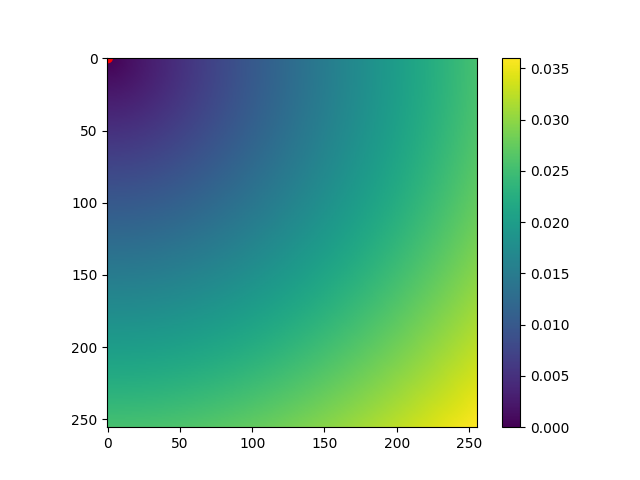

In [268]:
width = 256
height = 256
unit_position = np.array([0., 0.])

def update(
    unit_range = 10.0,
    unit_speed = 2.0,
    unit_health = 100.0,
    unit_dps = 2.0,
    enemy_range = 1.0,
    enemy_speed = 0.1,
    enemy_health = 100.0,
    enemy_dps = 2.0,
):

    def f(x):

        value = 0.0
        eps = 1e-8
        for y in enemy_positions:
            d = np.linalg.norm(x - y)

            # if unit_range < d <= enemy_range:
            #     value += 1
            # elif enemy_range < d <= unit_range:
            #     value -= 1

            unit_margin = max(0, d - unit_range) / max(eps, unit_speed)
            enemy_margin = max(0, d - enemy_range) / max(eps, enemy_speed)
            value += unit_margin
            value -= enemy_margin
            # unit_kill_time = enemy_health / max(eps, unit_dps)
            # enemy_kill_time = unit_health / max(eps, enemy_dps)
            # value += unit_kill_time
            # value -= enemy_kill_time

            # value += 1e-2 * d

        value += 1e-4 * np.linalg.norm(x - unit_position)
        return value

    values = np.array([[f(np.array((xi, yi))) for xi in range(width)] for yi in range(height)])
    # print(values.sum())
    return values

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
image = ax.imshow(np.zeros((width, height)))
plt.colorbar(image, ax=ax)

def draw(**kwargs):
    for p in ax.patches:
        p.remove()

    data = update(**kwargs)
    optimum = np.unravel_index(data.argmin(), data.shape, order="F")
    ax.add_patch(Circle(optimum, radius=3, color="red"))
    # ax.imshow(data)
    image.set_array(data)
    image.set_clim(vmin=data.min(),vmax=data.max())
    #fig.canvas.draw()
    # return image

bounds_dps = (0, 10, .1)
bounds_range = (0, 100, 1)
bounds_speed = (0, 5, .1)
bounds_health = (0, 300, 1)

def button_press_event(event):
    # for p in ax.patches:
    #     p.remove()
    # ax.add_patch(Circle((event.xdata, event.ydata), radius=3, color="red"))
    if event.button is MouseButton.LEFT:
        unit_position[0] = event.xdata
        unit_position[1] = event.ydata
    widget.update()

fig.canvas.mpl_connect("button_press_event", button_press_event)

widget = interactive(draw,
    unit_range = bounds_range,
    unit_speed = bounds_speed,
    unit_health = bounds_health,
    unit_dps = bounds_dps,
    enemy_range = bounds_range,
    enemy_speed =bounds_speed,
    enemy_health = bounds_health,
    enemy_dps = bounds_dps,
)
display(widget)